# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

##  Установка библиотек


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#Библиотека по выводу пропусков
!pip install missingno -U

import missingno as msno

In [4]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
print('ДУБЛИ:', data.duplicated().sum())

data.describe()

ДУБЛИ: 0


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Выводим гистограмы**

**Вывод**

- Всего у нас 23699 записи. У многих столбцов есть пропущенные значения и некорректный тип данных. Встречаются аномальные значения

### Предобработка данных

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Вывод тепловой карты пропусков**

<Axes: >

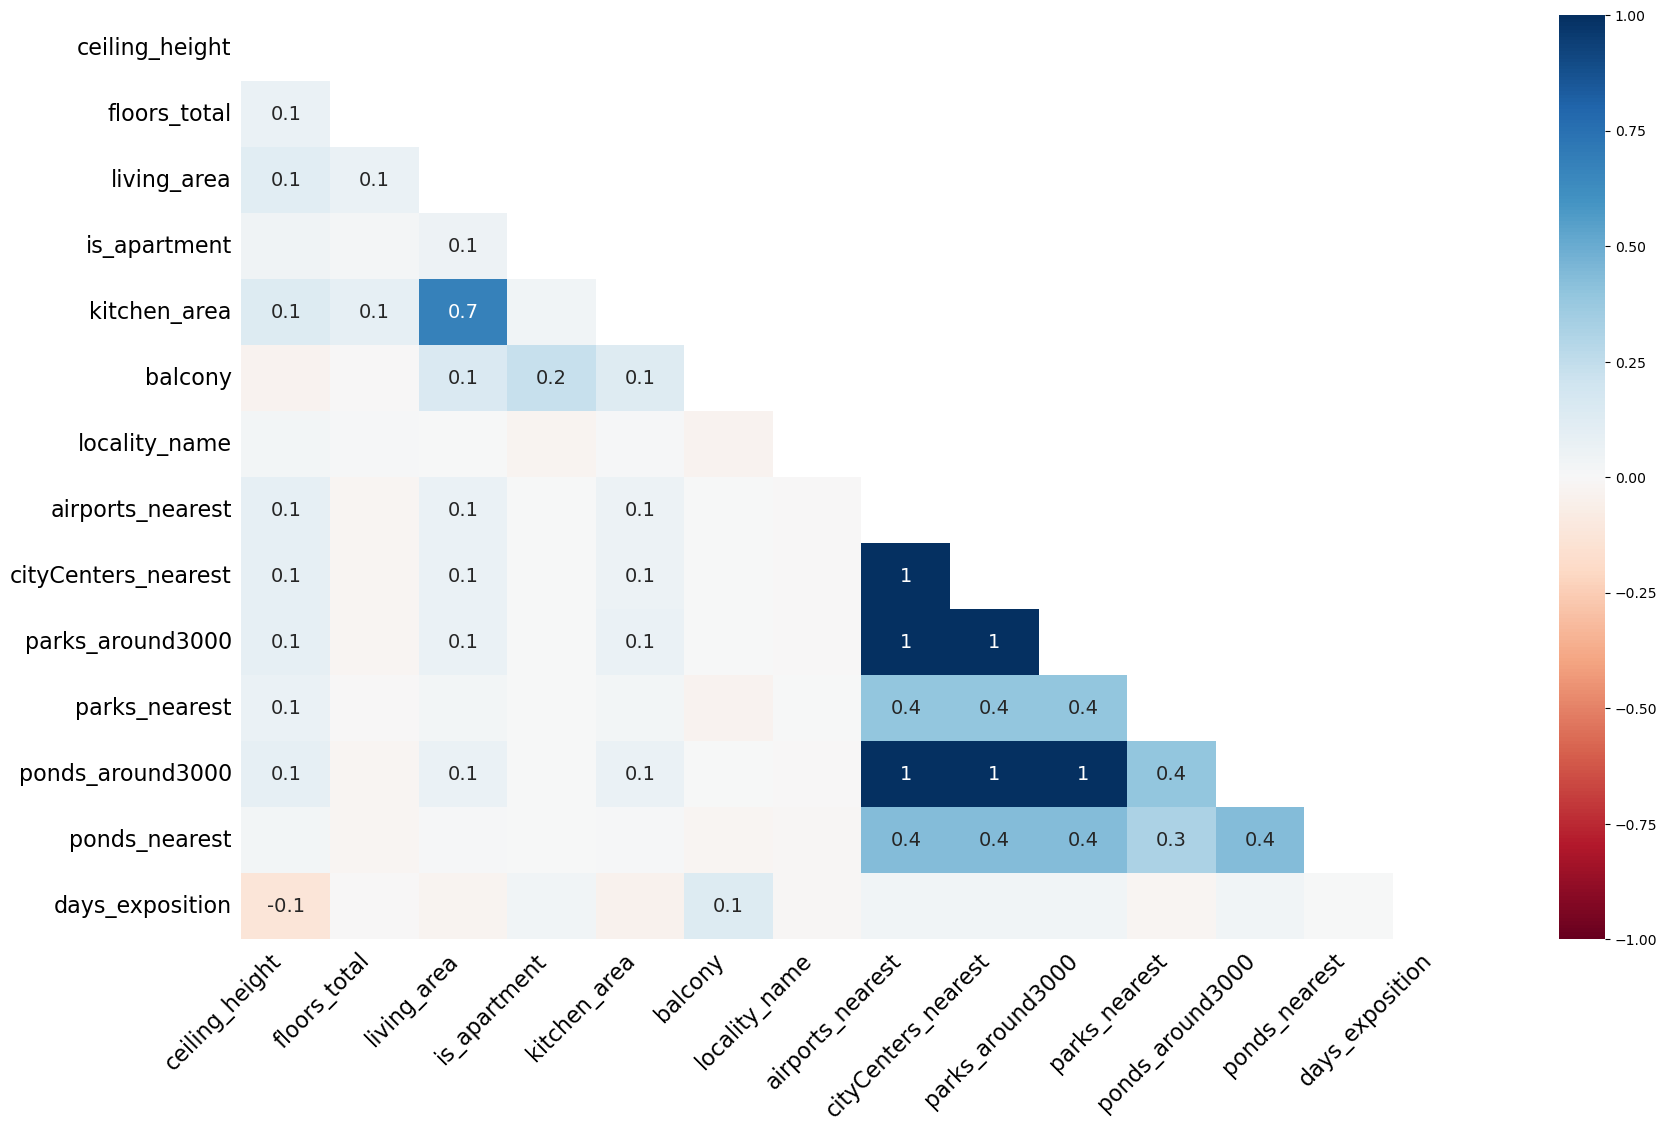

In [9]:
 msno.heatmap(data)

**Вывод:** Тепловая карта показывает на сколько влияние пропусков в данных влияет на покозатели

In [14]:
null_obj = ['floors_total', 'balcony','airports_nearest','cityCenters_nearest',
            'parks_around3000', 'parks_nearest', 'ponds_around3000','ponds_nearest', 'days_exposition']

for i in null_obj:
    data[i] = data[i].fillna(0)
    
data['is_apartment'] = data['is_apartment'].fillna(False)

Удаляем записи где незаполнена локация, по причине не возможности определить место положение

Высоту потолков заменяем на медианное значение

In [17]:
data['ceiling_height'] = data.groupby(['locality_name', 'floors_total'])['ceiling_height'].apply(lambda x: x.fillna(x.median()))
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
data.dropna(subset=['locality_name'], inplace=True)


/var/folders/62/56gj0wtd5k7g0l74ks3f86gw0000gn/T/ipykernel_15153/1715440997.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['ceiling_height'] = data.groupby(['locality_name', 'floors_total'])['ceiling_height'].apply(lambda x: x.fillna(x.median()))


Для объектов площадь кухни и жилая площадь пропуски заполняем медианным значением

In [18]:
data['living_area'].fillna(data['living_area'].mean() / data['total_area'].median() * data['total_area'], inplace=True)
data['kitchen_area'].fillna(data['kitchen_area'].mean() / data['total_area'].median() * data['total_area'], inplace=True)

In [19]:
#Проверка успешности замены пустых значений
data.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

**Вывод**

- Для большенства значений где было возмодно значения заполнил на 0 чтоб не потерять данные
- Удаляем записи где незаполнена локация, по причине не возможности определить место положение

- Высоту потолков заменяем на медианное значение

**Появление пропусков:**

`ceiling_height` - Поле является не обязательным для заполнения, так же можно предположит на первом этапе что могли быть потери данных при выгрузке или записи;

`floors_total` - Скорее всего упричиной пропусков является не обязательное поле при заполнении, а в строении просто нет этажей;

`living_area` - Скорее всего причиной пропусков является не обязательное поле при заполнении или техническая ошибка при выгрузке данных или сбои в работе приложения; 

`kitchen_area` - Поле может быть не обязательным, потери данных при обмене или выгрузке, так же можно предположить, что поле может быть не заполнено для студий, где площадь кухни относится к жилой площади;

`balcony` - Поле может быть не обязательным, потери данных при обмене или выгрузке, так же можно предположить, что в квартире нет балконов не зависимо от этажа;

`locality_name` - Скорее всего ошибка при обмене или выгрузке данных, так же есть вероятность, что поле может быть не обязательным и пользователь при заполнении  не нашел своей локации и пропустил заполнение;

`airports_nearest` - Поле может быть не обязательным для заполнения и пользователь мог пропустить заполнение так как в городе или ПГТ нет аэропортов;

`cityCenters_nearest` - Поле может быть не обязательным для заполнения и пользователь мог пропустить заполнение так как в городе или ПГТ нет аэропортов;

`parks_around3000` - Поле может быть не обязательным для заполнения и пользователь мог пропустить заполнение так как рядом нет парковых зон;

`parks_nearest` - Поле может быть не обязательным для заполнения и пользователь мог пропустить заполнение так как рядом нет парковых зон; 

`ponds_around3000` - Поле может быть не обязательным для заполнения и пользователь мог пропустить заполнение так как рядом нет водоемов; 

`days_exposition` - Скорее всего потеря данных или на стороне БД запись значения "0"  воспринимается как пропуск.


**2.2 Приведение типов данных**

Для полей: Цена, кол-во комнат, кол-во балконов, кол-во парков, кол-во прудов производим приведение к типу данных `int`
для поля дата производим приведение к типу `datetime`

In [21]:
data_int_obj = ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']
for i in data_int_obj:
    data[data_int_obj] = data[data_int_obj].astype(int)

#Приводим first_day_exposition к типу Дата
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [22]:
#Проверяем результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

**Вывод**

- Пля с типом инт приведены к числовому формату для удобства расчетов и корректности отображения данных

- Дата время так же приведены к корректному типу данных

**2.3 Поиск уникальных значений**

In [23]:
#подсчет количества значений до изменения
data['locality_name'].nunique()

364

In [24]:
locality_rename = []
for item in data['locality_name']:
    item = item.replace("посёлок", "поселок")
    item = item.replace("поселок Рябово", "поселок городского типа Рябово")
    locality_rename.append(item)

data['locality_name'] = locality_rename

In [25]:
#подсчет количества значений после изменения
data['locality_name'].nunique()

329

**2.3 Аномальные значения**

In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.737999,10.637505,35.046714,5.893277,10.655076,0.591712,22063.392812,10889.429006,0.469091,167.359789,0.590359,199.009471,156.448964
std,5.682278,1.089640e+07,35.661808,1.078620,1.007367,6.613891,22.852053,4.883317,6.179838,0.959662,16463.306970,9635.531486,0.748458,306.832134,0.883539,305.203376,213.564548
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,7.000000,0.000000,10147.000000,2242.000000,0.000000,0.000000,0.000000,0.000000,22.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.200000,4.000000,9.200000,0.000000,21868.000000,11250.000000,0.000000,0.000000,0.000000,0.000000,73.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.750000,16.000000,42.700000,8.000000,12.000000,1.000000,34358.000000,15247.000000,1.000000,301.000000,1.000000,389.000000,198.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,418.017546,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


К аномальным значениям попали квартиры с высотой потолков более 10 м (для каждого значения подготовлены среднии показатели)

In [27]:
#по id 5807 примем проверку изменения
data.loc[5807]

total_images                             17
last_price                          8150000
total_area                             80.0
first_day_exposition    2019-01-09 00:00:00
rooms                                     2
ceiling_height                         27.0
floors_total                             36
living_area                            41.0
floor                                    13
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                           12.0
balcony                                   5
locality_name               Санкт-Петербург
airports_nearest                    18732.0
cityCenters_nearest                 20444.0
parks_around3000                          0
parks_nearest                           0.0
ponds_around3000                          3
ponds_nearest                          80.0
days_exposition                        38.0
Name: 5807, dtype: object

In [28]:
data['ceiling_height'].unique()

for item in data['ceiling_height'].unique():
    if item > 10 and item < 14:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 1.3
    elif item >= 14 and item < 20:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 1.4
    elif item >= 20 and item <= 24:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 2.2
    elif item >= 25 and item < 27:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 2.5
    elif item >= 27 and item < 30:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 2.7
    elif item >= 30 and item < 33:
        data.loc[data['ceiling_height'] == item, 'ceiling_height'] = 3.2

**Комментарий**

Выбивающиеся значения: 

`last_price` - Не стал брать максимальное значение так стоимость реально может быть такой;

`total_area` - Не стал брать максимальное значение так как оно может быть действительным и люди продают дворец по аналогии Краснодарского));

`rooms` - Максимальное не стал брать так как возможно для дворца с большой площадью такое кол-во номеров это нормально, а вот минимальное значение я скорее всего пропустил, так как не знал что делать с ним и хотел посмотреть на влияние, а потом забыл удалить.

`floors_total` - В принципе многоэтажка таких гоборитов это реально. А минимальное значение скорее всего частные дома (и мы это проверим). И по хорошему эти значения можно заполнить значением "1" и посмотреть как они буду влиять на покозатели;

`living_area` - Вопрос к минимальному значению ниже я приведу аналитику почему я ее не взял;

`balcony` - Ну минимальное значение связано с тем что балконов просто нет;

`airports_nearest` - Минимальное значение не анамалия, скорее всего в городе просто нет аэропората;

`cityCenters_nearest` - Возможно минимальное значение это нормально, так как в ПГТ может не быть центральных улиц;

`parks_around3000`, `ponds_nearest` - возможно тоже самое

`days_exposition` - Это квартиры которые продались в первый день публикации, возможно правильным решением стоит таким результатам присвоить знгачение "1" как продажа в первый день



**Проверка выбивающихся значений и их кол-во:**


**1. Комнаты**

In [29]:
print('Кол-во выбивающихся значений в комнатах по min значению:', data[data['rooms'] == 0]['rooms'].count())

Кол-во выбивающихся значений в комнатах по min значению: 197


**Вывод:** 197 объектов из 23650 не содержат информацию по квартирам - это 8% от всего Dataset. 

Предположим, что квартиры где незаполнены комнаты это студии. Значит площадь данных квартир не должна выходить за 45кв.м. 


In [31]:
data[data['rooms'] == 0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000,27.00,2017-03-30,0,2.700,24,15.500000,2,False,...,5.486401,2,поселок Мурино,0.0,0.0,0,0.0,0,0.0,181.0
349,4,2320000,25.00,2017-09-27,0,2.725,14,17.000000,1,False,...,5.080001,0,деревня Кудрово,0.0,0.0,0,0.0,0,0.0,45.0
440,8,2480000,27.11,2018-03-12,0,2.700,17,24.750000,4,False,...,5.508754,2,Санкт-Петербург,38171.0,15015.0,0,0.0,2,982.0,64.0
508,0,3375000,34.40,2017-03-28,0,2.600,26,24.300000,19,False,...,6.990082,1,поселок Парголово,53115.0,19292.0,0,0.0,1,593.0,430.0
608,2,1850000,25.00,2019-02-20,0,2.600,10,16.561709,7,False,...,5.080001,0,поселок Шушары,0.0,0.0,0,0.0,0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000,26.00,2017-09-01,0,2.750,25,18.000000,16,False,...,5.283201,0,Санкт-Петербург,11405.0,13222.0,0,0.0,1,623.0,14.0
23442,0,2500000,27.70,2017-09-28,0,2.700,24,18.000000,4,False,...,5.628642,2,поселок Мурино,0.0,0.0,0,0.0,0,0.0,4.0
23554,15,3350000,26.00,2018-09-07,0,2.750,19,17.224178,8,False,...,5.283201,0,Санкт-Петербург,18090.0,17092.0,0,0.0,2,112.0,31.0
23592,10,1450000,29.00,2017-11-11,0,2.600,9,18.000000,8,False,...,5.892802,2,Никольское,0.0,0.0,0,0.0,0,0.0,82.0


In [32]:
data[(data['rooms'] == 0) & (data['kitchen_area'] == 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Таких квартир нет, тогда предполагаем что все эти квартиры являются студиями вместо значения 0 присваиваем 1

In [33]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

**2. Этажей в здании**

In [34]:
print('Кол-во незаполненых значений в колонке этажей всего', data[data['floors_total'] == 0]['floors_total'].count())

Кол-во незаполненых значений в колонке этажей всего 85


Неожиданный результат. 
Есть 4 варианта решения: 
- удалить 85 показателей из сета
- оставить все как есть
- принять что каждая из этих квартир находится на последнем этаже и прировнять их
- запросить данные у команды разработки

Принимаем что каждая из квартир находится на последнем этаже

In [37]:
data.loc[data['floors_total'] == 0, 'floors_total'] = data['floor']
data[data['floors_total'] == 0]['floors_total'].count()

0

**3. Жилая площадь**

In [38]:
print('Кол-во выбивающихся значений по жилой площади:', data[data['living_area'] < 10]['living_area'].count())

Кол-во выбивающихся значений по жилой площади: 30


Посмотрим на эти показатели ближе.
Создадим отдельную переменную в которую поместим значения площади по квартире для манипуляции с ними

In [40]:
living_area = data.query('living_area < 10')
living_area = living_area[['total_area', 'living_area', 'kitchen_area','rooms', 'balcony']]
display(living_area.query('total_area > 30 and (rooms < 2)'))

,total_area,living_area,kitchen_area,rooms,balcony
680,43.0,9.0,23.0,1,0
3242,41.0,3.0,11.0,1,0
4100,34.8,9.0,17.1,1,0
15833,33.0,9.0,14.3,1,1
16431,31.0,6.0,17.0,1,0
17248,33.0,8.9,16.1,1,1
19251,33.0,6.5,18.0,1,0
19620,33.0,9.0,17.0,1,0
21505,35.3,8.5,16.1,1,2
21908,46.3,9.8,26.0,1,0


Добавим в таблицу дополнительные столбцы 
1. Сумма жилой площади и кухни
2. Разница между общей площадью и суммой жилой площади

In [41]:
living_area['sum_living_kitchen'] = living_area['living_area'] + living_area['kitchen_area']
living_area['difference_living_kitchen'] = living_area['total_area'] - living_area['sum_living_kitchen']

display(living_area.query('total_area > 30 and (rooms < 2)'))

,total_area,living_area,kitchen_area,rooms,balcony,sum_living_kitchen,difference_living_kitchen
680,43.0,9.0,23.0,1,0,32.0,11.0
3242,41.0,3.0,11.0,1,0,14.0,27.0
4100,34.8,9.0,17.1,1,0,26.1,8.7
15833,33.0,9.0,14.3,1,1,23.3,9.7
16431,31.0,6.0,17.0,1,0,23.0,8.0
17248,33.0,8.9,16.1,1,1,25.0,8.0
19251,33.0,6.5,18.0,1,0,24.5,8.5
19620,33.0,9.0,17.0,1,0,26.0,7.0
21505,35.3,8.5,16.1,1,2,24.6,10.7
21908,46.3,9.8,26.0,1,0,35.8,10.5


Добавим еще одно условие, кол-во балконов < 1 и будем делать выводы

In [42]:
display(living_area.query('total_area > 30 and (rooms < 2) and (balcony < 1)'))

,total_area,living_area,kitchen_area,rooms,balcony,sum_living_kitchen,difference_living_kitchen
680,43.0,9.0,23.0,1,0,32.0,11.0
3242,41.0,3.0,11.0,1,0,14.0,27.0
4100,34.8,9.0,17.1,1,0,26.1,8.7
16431,31.0,6.0,17.0,1,0,23.0,8.0
19251,33.0,6.5,18.0,1,0,24.5,8.5
19620,33.0,9.0,17.0,1,0,26.0,7.0
21908,46.3,9.8,26.0,1,0,35.8,10.5
23208,37.0,8.0,22.0,1,0,30.0,7.0


In [43]:
display(living_area.query('total_area > 30 and (rooms > 1)'))

,total_area,living_area,kitchen_area,rooms,balcony,sum_living_kitchen,difference_living_kitchen
1326,52.00,9.0,32.0,2,2,41.0,11.00
2309,62.40,8.4,41.0,2,2,49.4,13.00
8325,52.00,9.0,6.0,2,1,15.0,37.00
13915,52.00,2.0,9.0,2,0,11.0,41.00
20994,50.60,8.0,31.0,2,0,39.0,11.60
21943,77.60,5.4,9.8,4,0,15.2,62.40
22473,33.26,9.1,16.4,2,0,25.5,7.76
23574,139.00,3.0,16.0,3,1,19.0,120.00


**Вывод:**

Можно предположить:
1. Что все квартиры где общая площадь > 30 и кол-во комнат < 2 являются студиями 
2. Для квартир где общая площадь > 30 и кол-во комнат > 1 являются евро-двушками где кухня совместо с залом


Но среди них есть так же анамальное значение 3242 где остаток разницы 27 кв.м и 23574 с разницой 120 кв.м

**4. Сколько дней было размещено объявление**

In [44]:
print('Кол-во квартир продавшихся в день публикации:', data[data['days_exposition'] < 1]['days_exposition'].count())

Кол-во квартир продавшихся в день публикации: 3180


На самом деле данный показатель обобщеный, в выгрузке явно не хватает дополнительных признаков - это статус и дата снятия. 
Где:
- статус причина снятия
- дата снятия - фактическая дата перевода объявления из одного статуса в другой


Предположения: 
- Объявление так и не было опубликованно
- Квартира действительно была куплена день в день
- Произошла техническая ошибка


**Вывод**

dataset содержит большое количество разных данных. 

В нем есть анамалии допущенные пользователями при создании объявления скорее всего это может быть вызванно фактарами:
- В системе были не настроены контроли ввода и пользователи их пропустили
- Пользователи намерено указали некорректные данные 

Так же аномалии могут быть вызваны по техническим причинам
- Потерялись данные при выгрузки
- При записи произошла данных в систему произошла ошибка

**3.1 Расчитываем стоимость одного квадрата и добавляем в таблицу**

In [47]:
data['price_one_m'] = data['last_price'] / data['total_area']
data['price_one_m'] = data['price_one_m'].astype(int)
#проверяем добавление данных
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_m
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0.0,120370
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,2,поселок Шушары,12817.0,18603.0,0,0.0,0,0.0,81.0,82920
2,10,5196000,56.0,2015-08-20,2,2.60,5,34.300000,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785
3,0,64900000,159.0,2015-07-24,3,2.60,14,105.332472,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000


**3.2 Добовляем столбцы: день, месяц, год публикации**

In [49]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
#проверяем добавление данных
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_m,weekday,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,16028.0,1,482.0,2,755.0,0.0,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,18603.0,0,0.0,0,0.0,81.0,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.60,5,34.300000,4,False,...,13933.0,1,90.0,2,574.0,558.0,92785,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.60,14,105.332472,9,False,...,6800.0,2,84.0,3,234.0,424.0,408176,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,8098.0,2,112.0,1,48.0,121.0,100000,1,6,2018


**3.3 Добовляем тип этажа квартиры через функцию**

In [50]:
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(type_floor, axis=1)

In [51]:
#проверяем добавление данных
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_m,weekday,month,year,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,1,482.0,2,755.0,0.0,120370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0,0.0,0,0.0,81.0,82920,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.60,5,34.300000,4,False,...,1,90.0,2,574.0,558.0,92785,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.60,14,105.332472,9,False,...,2,84.0,3,234.0,424.0,408176,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,2,112.0,1,48.0,121.0,100000,1,6,2018,другой


**3.4 Добовляем расстояние до центра города в километрах**

In [53]:
data['km_cityCenters'] = data['cityCenters_nearest'] / 1000
data['km_cityCenters'] = data['km_cityCenters'].astype(int)
#проверяем добавление данных
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_m,weekday,month,year,floor_type,km_cityCenters
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,0.0,120370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,0,0.0,81.0,82920,1,12,2018,первый,18
2,10,5196000,56.0,2015-08-20,2,2.60,5,34.300000,4,False,...,90.0,2,574.0,558.0,92785,3,8,2015,другой,13
3,0,64900000,159.0,2015-07-24,3,2.60,14,105.332472,9,False,...,84.0,3,234.0,424.0,408176,4,7,2015,другой,6
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,100000,1,6,2018,другой,8


### Проведение исследовательского анализа данных

**4.1 Изучаем параметры объектов**

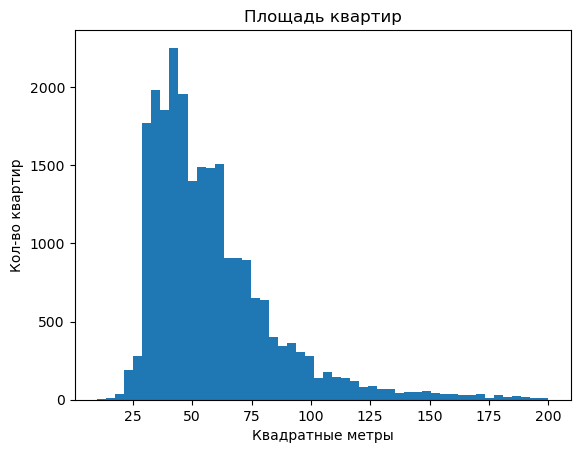

Квартиры с наибольшей площадью:
19540    900.0
12859    631.2
3117     631.0
15651    618.0
5358     590.0
4237     517.0
8018     507.0
15016    500.0
5893     500.0
12401    495.0
Name: total_area, dtype: float64


In [54]:
plt.hist(data['total_area'], bins=50, range=(10,200))
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры с наибольшей площадью:')
print(data['total_area'].sort_values(ascending=False).head(10))

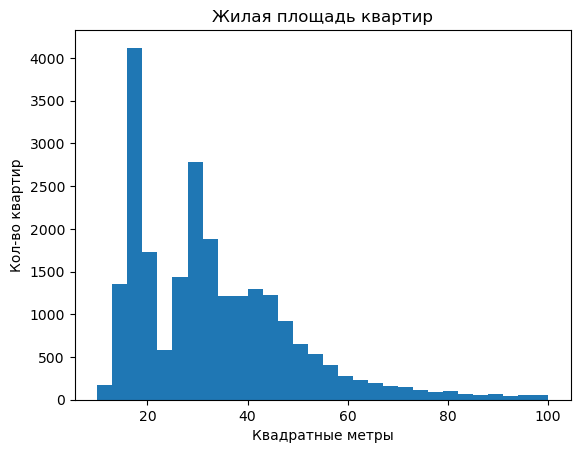

Квартиры с наибольшей жилой площадью:
3117     418.017546
19540    409.700000
5358     409.000000
12401    347.500000
4237     332.000000
5893     331.234189
15016    331.234189
9826     327.325625
12859    322.300000
660      312.500000
Name: living_area, dtype: float64


In [55]:
plt.hist(data['living_area'], bins=30, range=(10,100))
plt.title('Жилая площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры с наибольшей жилой площадью:')

print(data['living_area'].sort_values(ascending=False).head(10))

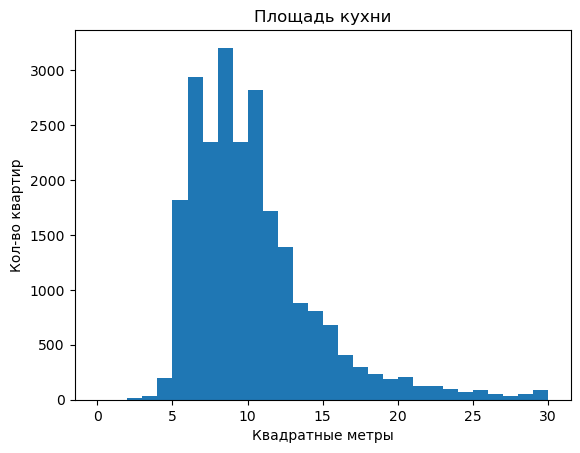

Кухни с наибольшей площадью:
19540    112.000000
20215    107.000000
15016    101.600028
2489     100.700000
9826     100.401147
5358     100.000000
16239     93.200000
16797     93.000000
10867     87.200000
22131     85.791063
Name: kitchen_area, dtype: float64


In [56]:
plt.hist(data['kitchen_area'], bins=30, range=(0, 30))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Кол-во квартир')
plt.show()
print('Кухни с наибольшей площадью:')

print(data['kitchen_area'].sort_values(ascending=False).head(10))

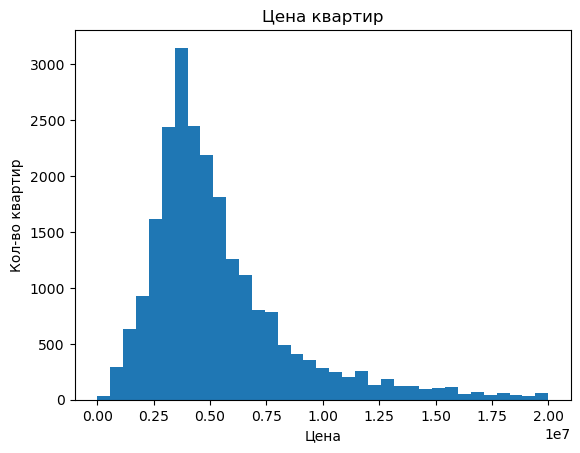

Квартиры с наибольшей стоимостью:
12971    763000000
19540    420000000
14706    401300000
1436     330000000
15651    300000000
22831    289238400
16461    245000000
13749    240000000
5893     230000000
8900     190870000
Name: last_price, dtype: int64


In [57]:
plt.hist(data['last_price'], bins=35, range=(0,20000000))
plt.title('Цена квартир')
plt.xlabel('Цена')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры с наибольшей стоимостью:')
print(data['last_price'].sort_values(ascending=False).head(10))

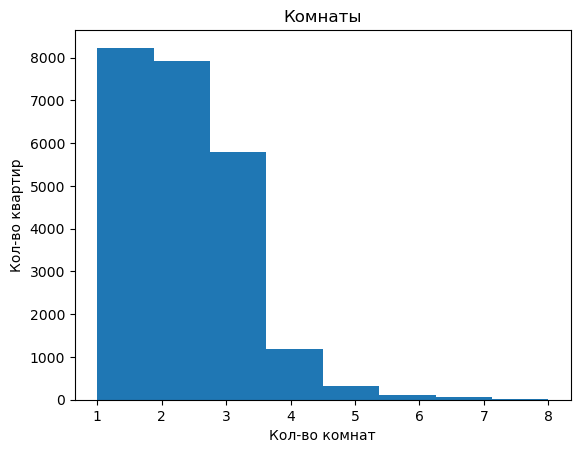

Квартиры с наибольшим кол-ом комнат:
14498    19
18848    16
5358     15
866      14
20829    14
19540    12
9688     11
648      11
18891    10
4149     10
Name: rooms, dtype: int64


In [58]:
plt.hist(data['rooms'], bins=8, range=(1,8))
plt.title('Комнаты')
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры с наибольшим кол-ом комнат:')
print(data['rooms'].sort_values(ascending=False).head(10))

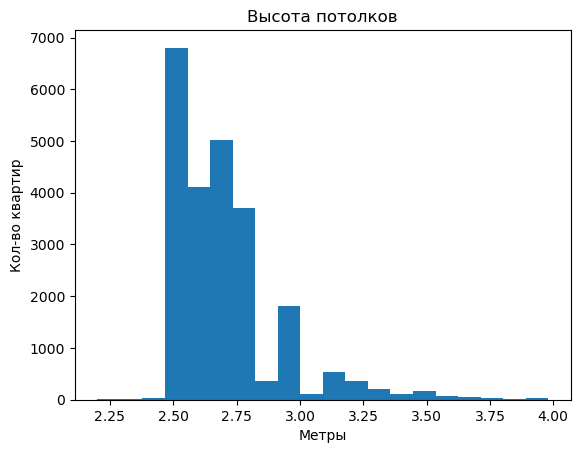

Квартиры с наибольшей высотой потолков:
22869    100.0
5863       8.3
3474       8.0
15743      8.0
17442      8.0
20264      6.0
21227      5.8
1388       5.6
7578       5.5
1026       5.3
Name: ceiling_height, dtype: float64


In [59]:
plt.hist(data.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=20)

plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры с наибольшей высотой потолков:')
print(data['ceiling_height'].sort_values(ascending=False).head(10))

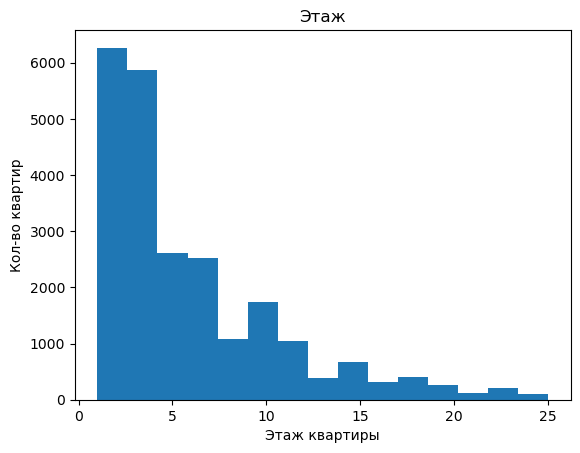

Квартиры на самом высоком этаже:
18218    33
11575    32
18629    31
1917     30
11079    29
397      28
6157     27
13276    27
4091     27
23292    27
Name: floor, dtype: int64


In [60]:
plt.hist(data['floor'], bins=15, range=(1,25))
plt.title('Этаж')
plt.xlabel('Этаж квартиры')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры на самом высоком этаже:')
print(data['floor'].sort_values(ascending=False).head(10))

кол-во квартир по типу


floor_type
другой       17326
первый        2912
последний     3412
Name: floor_type, dtype: int64

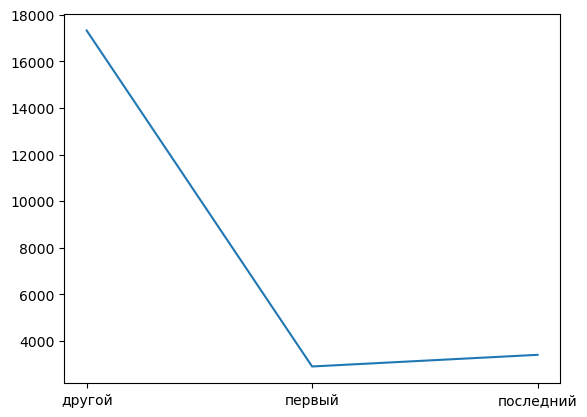

In [61]:
grouped = data.groupby('floor_type')['floor_type'].count()
print('кол-во квартир по типу')
display(grouped)
plt.plot(grouped)

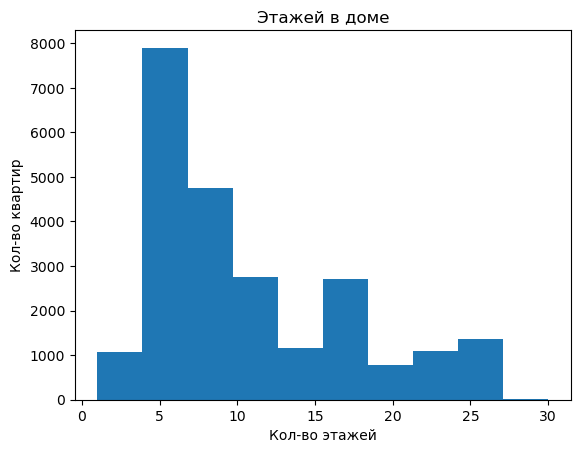

Квартиры в многоэтажках:
2253     60
16731    52
16934    37
397      36
11079    36
5807     36
18617    35
18629    35
2966     35
20938    35
Name: floors_total, dtype: int64


In [62]:
plt.hist(data['floors_total'], bins=10, range=(1,30))
plt.title('Этажей в доме')
plt.xlabel('Кол-во этажей')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры в многоэтажках:')
print(data['floors_total'].sort_values(ascending=False).head(10))

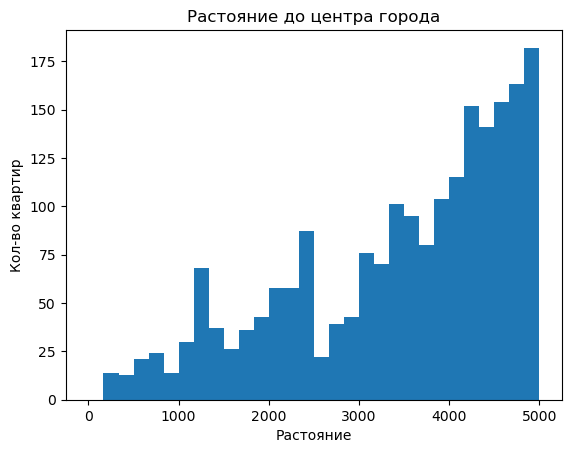

Квартиры самые далекие от центра города:
9640     65968.0
5340     65952.0
577      65764.0
20746    65105.0
5218     64857.0
18884    62706.0
2974     62454.0
16569    61495.0
23123    60223.0
4441     59626.0
Name: cityCenters_nearest, dtype: float64


In [63]:
plt.hist(data['cityCenters_nearest'], bins=30, range=(1,5000))
plt.title('Растояние до центра города')
plt.xlabel('Растояние')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры самые далекие от центра города:')
print(data['cityCenters_nearest'].sort_values(ascending=False).head(10))

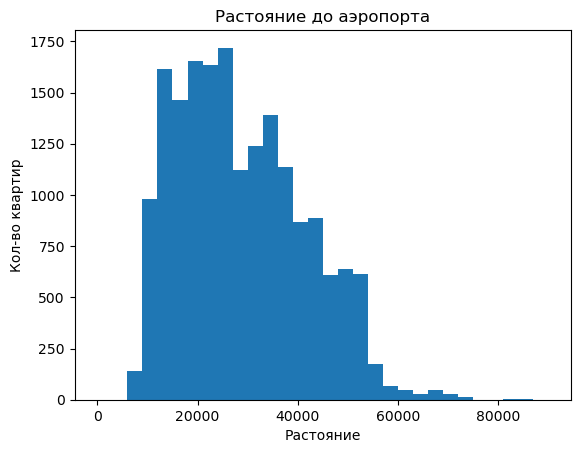

Квартиры удаленные аэропорта:
9640     84869.0
5340     84853.0
577      84665.0
20746    84006.0
5218     83758.0
18884    81607.0
2974     81355.0
4441     78527.0
939      75646.0
376      73827.0
Name: airports_nearest, dtype: float64


In [64]:
plt.hist(data['airports_nearest'], bins=30, range=(1,90000))
plt.title('Растояние до аэропорта')
plt.xlabel('Растояние')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры удаленные аэропорта:')
print(data['airports_nearest'].sort_values(ascending=False).head(10))

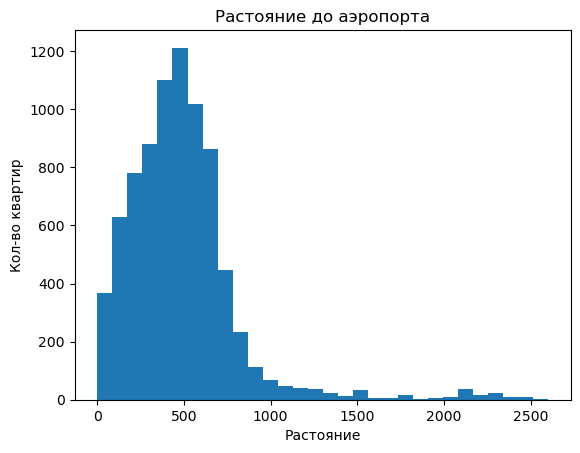

Квартиры удаленные от парка:
19430    3190.0
10959    3190.0
1590     3064.0
19208    3013.0
23080    2984.0
2659     2905.0
1860     2888.0
7855     2880.0
3865     2847.0
22003    2768.0
Name: parks_nearest, dtype: float64


In [65]:
plt.hist(data['parks_nearest'], bins=30, range=(1,2600))
plt.title('Растояние до аэропорта')
plt.xlabel('Растояние')
plt.ylabel('Кол-во квартир')
plt.show()
print('Квартиры удаленные от парка:')
print(data['parks_nearest'].sort_values(ascending=False).head(10))

**Площадь**
- Большинство квартир - менее 100 квадратных метров. В подборке есть несколько анамальных вариантов с площадью более 200 квадратных метров.

**Стоимость**
- В основном стоимость квартир - порядка 5 миллионов. 

**Комнаты**
- В основном квартиры состоят из 1, 2 и 3 комнат. Есть аномальные варианты с кол-вом комнат больше 7.

**Высота потолков**
- Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. Больше 4 метров высота потолков выглядит подозрительно. 

**Площадь кухни**
- Самые распространённые кухни - от 5 до 15 метров. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.

**Жилая площадь**
- Самые распространённые варианты с жилой площадью от 10 до 50 метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.


Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы

In [66]:
good_data = data.query('total_area < 100')

Диаграмма размаха площади квартиры после отсечения выбивающихся значений


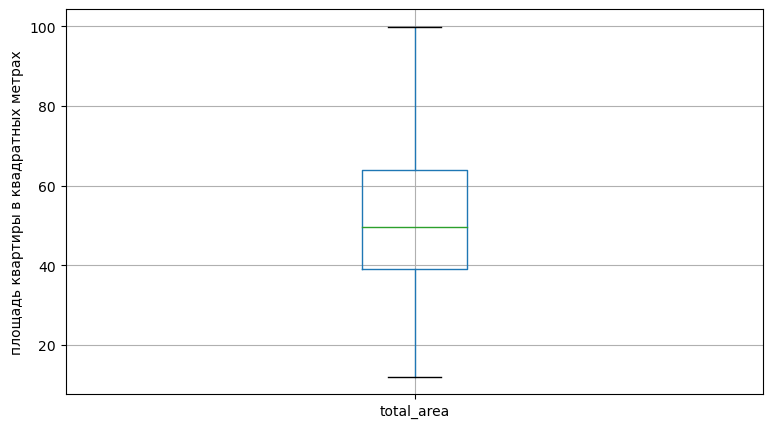

In [67]:
print('Диаграмма размаха площади квартиры после отсечения выбивающихся значений')
good_data.boxplot(column=['total_area'], figsize=(9,5), grid=True)
plt.ylabel('площадь квартиры в квадратных метрах')
plt.show()

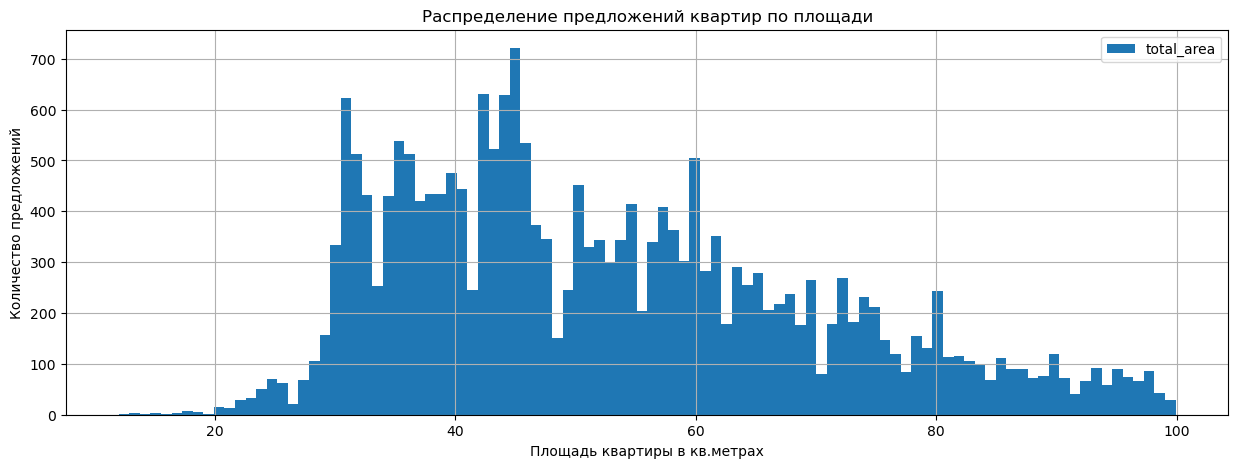

In [68]:
good_data.sort_values(by='total_area', ascending=True).plot(kind='hist', y='total_area',title='Распределение предложений квартир по площади',bins=100, figsize=(15,5), grid=True)

plt.xlabel('Площадь квартиры в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()

In [69]:
good_data = good_data.query('last_price < 9000000')

Диаграмма размаха высоты потолков


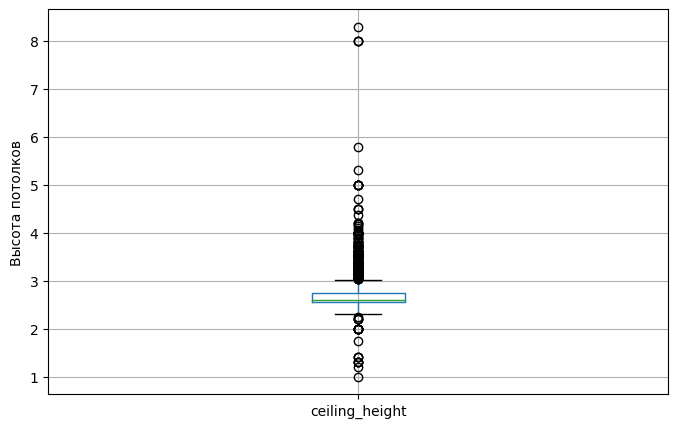

In [70]:
print('Диаграмма размаха высоты потолков')
good_data.boxplot(column=['ceiling_height'], figsize=(8,5), grid=True)

plt.ylabel('Высота потолков')
plt.show()

Изучим, зависит ли цена от площади, числа комнат, удалённости от центра.

In [72]:
good_data['city_centers_nearest'] = good_data['cityCenters_nearest']/1000

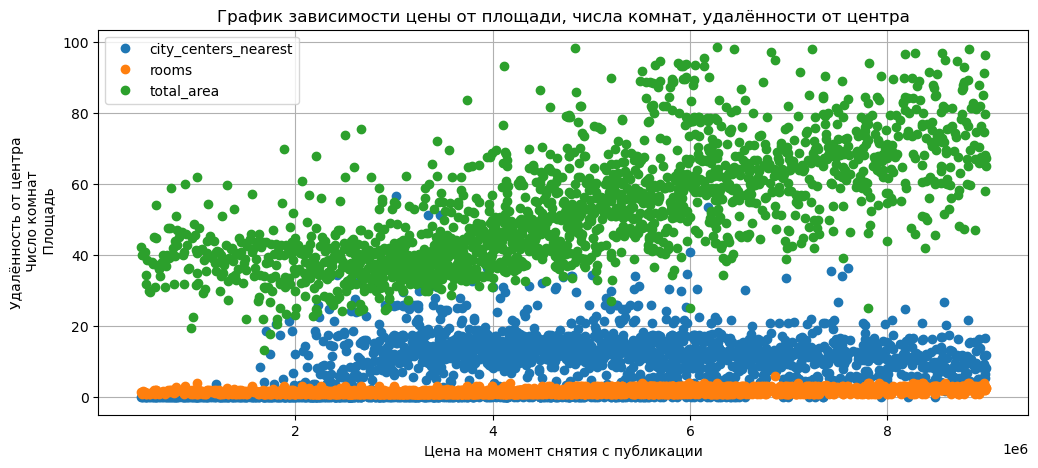

In [73]:
(good_data
    
     .pivot_table(index='last_price', values=['total_area','rooms','city_centers_nearest'])
     .plot(style='o',grid=True, figsize=(12, 5), title='График зависимости цены от площади, числа комнат, удалённости от центра')
)
plt.xlabel('Цена на момент снятия с публикации')
plt.ylabel('Удалённость от центра\n Число комнат\n Площадь')
plt.show()

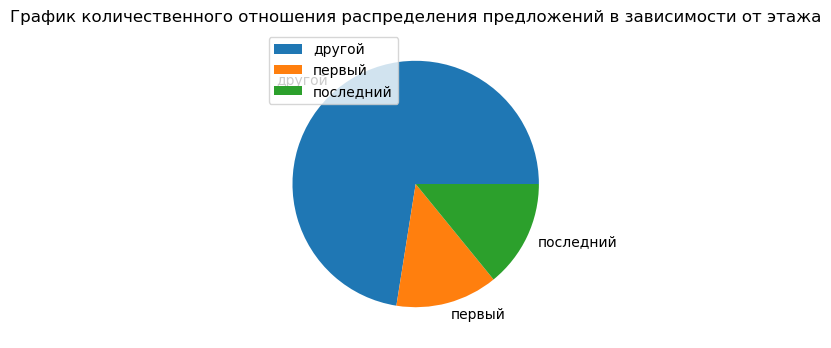

In [77]:
good_data.pivot_table(index='floor_type',values='last_price',aggfunc='count').plot.pie(y='last_price', figsize=(4,4), label='', title='График количественного отношения распределения предложений в зависимости от этажа')
plt.show()

**Вывод**
Глядя на графики становится очевидно, что ценится любой другой этаж здания кроме первого и последнего, как по цене, так и по количеству предложений на рынке. А так же очевидна зависимость цены от удалённости от центра и площади квартиры, чем квартира больше и ближе к центру, тем цена выше. Чего нельзя однозначно сказать о количестве комнат, здесь график цены меняется не так значительно.

**4.2 Срок продажи квартиры**

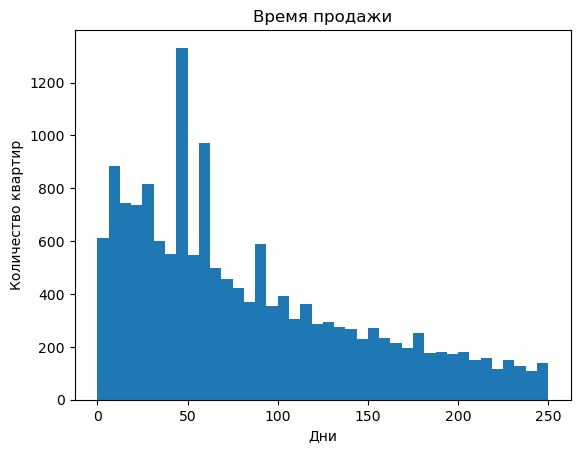

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [78]:
plt.hist(data.query('days_exposition > 0')['days_exposition'], bins=40, range=(0,250))
plt.title('Время продажи')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()
# Изучаем значения срока продажи
data.query('days_exposition > 0')['days_exposition'].describe()

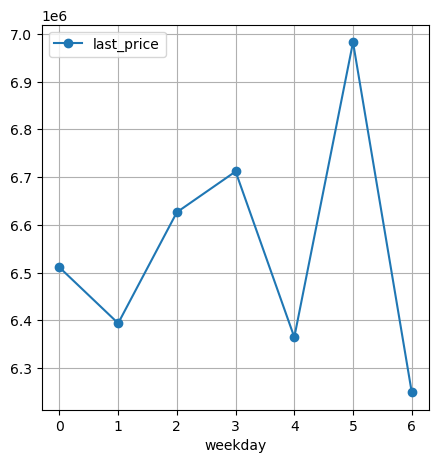

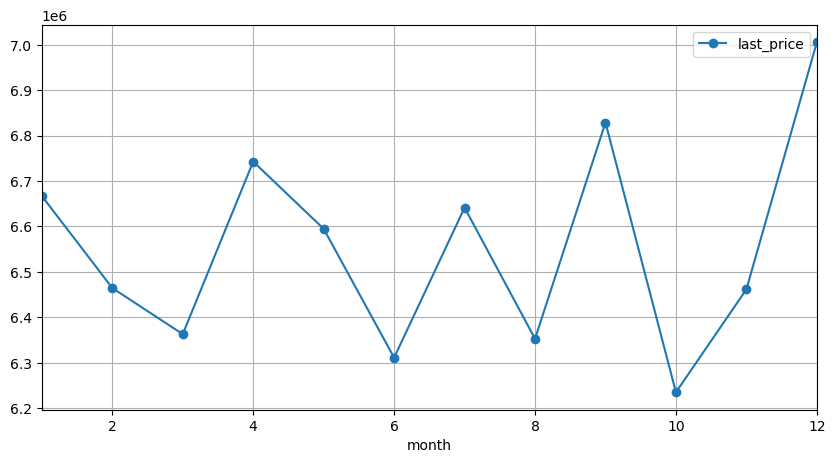

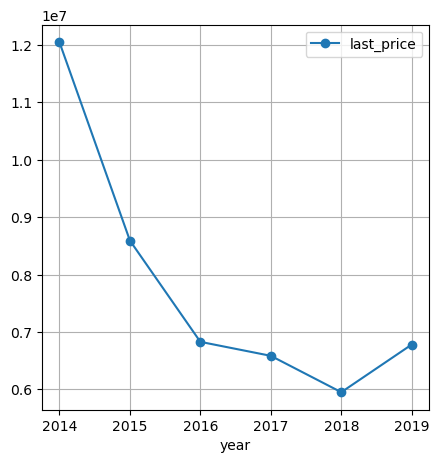

In [79]:
#Дата
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
#Месяц
(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', xlim=(1,12), figsize=(10, 5))
)
plt.show()
#Год
(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()

- Чем больше площадь, тем выше стоимость. Корреляция показателей самая высокая.
- Число комнат влияет на цену (больше комнат - больше цена), однако зависимость ниже, чем у площади.
- Кореляция жилой площади больше кореляции комнат

Можно сделать два вывода: бывают квартиры с большими по площади комнатами; квартиры в центре состоят из малого числа комнат, но стоят достаточно высоко.

**4.4 Сравнение средней стоимости в 10 городах**

In [85]:
city_ten = data['locality_name'].value_counts().head(10)
city_sm_price = data.query('locality_name in (@city_ten.index)').pivot_table(values='price_one_m', index='locality_name')
city_sm_price = city_sm_price.astype(int)
city_sm_price.sort_values('price_one_m', ascending=False)

,price_one_m
locality_name,
Санкт-Петербург,114848
Пушкин,103125
деревня Кудрово,92473
поселок Парголово,90175
поселок Мурино,85681
поселок Шушары,78676
Колпино,75424
Гатчина,68745
Всеволожск,68654


**вывод**

- Наибольшая средняя стоимость квадратного метра в Санкт-Петербурге.
- Затем идёт Пушкин.
- Районы входящие в пригород Санкт-Петербурга.
- Из 10 городов наименьшая стоимость в Гатчине и Всеволожске.

**4.5 Зависимость стоимости от центра**

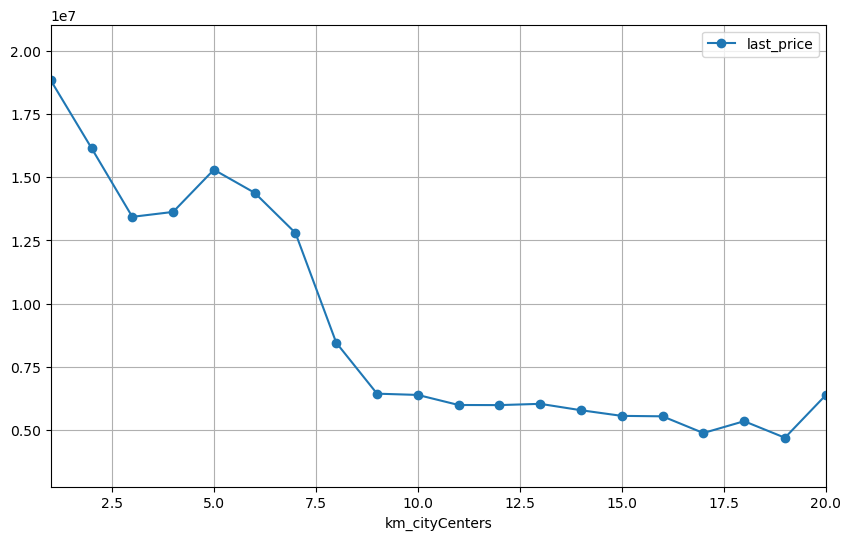

In [89]:

(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='km_cityCenters', values='last_price')
    .plot(grid=True, style='o-', xlim=(1,20), figsize=(10, 6))
)
plt.show()

### Общий вывод

1. Этап предподгатовки данных
    1.1 На этапе предподгатовки выявили большое кол-во пропусков которые могут влиять, как на средний показатель стоимости квартиры на рынке, стоимости одного квадратного метра
    1.2 Для того чтоб не удалять пустые значения, они были заполнены или медианными значениями, или данными преближенными к реальности на основании сопутствующих аналитик
    1.3 Предложения:
    - Необходимо проверить на корректно выставленные контроли обязательных полей при заполнении
    - Проверить на неявные дубликаты справочники где пользователи должны выбирать значения
    - Коллегамм подготавливающим данные обратить внимание на корректность подготовленых данных
2. Анализ:
    2.1 На стоимость квартиры несомнено влияет площадь квартиры, количество комнат в квартире
    2.2 Среди городов в Санкт - Петербурге стоимость квартир будет выше чем стоимость в регионах
    2.3 Количество объявления в г. Санкт - Петербург будет больше
    2.4 Есть зависимость стоимости квартир по удаленности от центра. Чем дальше от центра тем стоимость ниже
    